
### 미션: Animal Rescue Drone - 동물 구조 드론 AI

🐾 **배경 스토리:**

2025년, 환경 파괴와 기후 변화로 인해 많은 야생 동물들이 서식지를 잃고 도심 지역으로 유입되고 있습니다.
이로 인해 구조 요청이 급증하고 있으며, 이를 해결하기 위해 **Animal Rescue Drone** 팀이 결성되었습니다.
당신은 드론에 탑재될 이미지 인식 모델을 개발하는 AI 엔지니어로 임명되었습니다.

당신의 임무는 **CNN 기반의 이미지 분류기**를 설계하여 드론이 도심에서 발견한 동물들을 빠르게 인식하고,
구조 요청이 필요한 동물들을 식별할 수 있도록 하는 것입니다.

---

🛠️ **미션 요구사항:**

1. **데이터셋 준비:**
   - **Caltech101** 데이터셋을 사용하여 고해상도 이미지를 활용합니다.
   - 동물 클래스: '고양이', '개', '새', '말', '사슴'
   - 비동물 클래스: '자동차', '비행기', '배', '트럭', '자전거'

   -또는 CIFAR-10 데이터셋을 사용하여 동물과 비동물(자동차, 비행기 등)을 분류합니다.

**Caltech101** 데이터셋 수동 다운로드 방법(URL이 변경되어 torchvision.dataset에서 자동 다운로드 안되며 아래 절차로 수동 다운로드 가능)

https://data.caltech.edu/records/mzrjq-6wc02
수동 다운로드를 진행하려면 다음 단계를 따르세요:

데이터 파일 다운로드
Caltech101 데이터셋은 두 개의 파일이 필요합니다.
이미지 파일: 101_ObjectCategories.tar.gz
어노테이션 파일: Annotations.tar
위 링크를 웹 브라우저에서 열어 파일을 다운로드합니다.
다운로드한 파일 저장 및 압축 해제

다운로드한 파일들을 예를 들어 ./data 폴더에 저장합니다.
터미널에서 아래와 같이 압축을 해제할 수 있습니다:

cd ./data
tar -xzvf 101_ObjectCategories.tar.gz
tar -xvf Annotations.tar

코드 수정
데이터셋 로드 시 download=True 대신 download=False로 설정하여, 이미 다운로드한 파일을 사용하도록 합니다.

   caltech_data = Caltech101(root='./data', download=False, transform=transform)
이렇게 수정하면 수동으로 다운로드한 데이터를 사용하여 모델을 학습할 수 있습니다.


2. **모델 설계:**
   - 기본적인 CNN 모델을 설계하고 학습시킵니다.
   - ResNet50 또는 VGG16의 **pretrained model**을 활용하여 Transfer Learning을 수행합니다.
   - 최종 출력층은 2개의 클래스(동물 vs 비동물)로 조정합니다.

3. **Fine Tuning:**
   - Transfer Learning에서 최종 Layer를 학습 가능한 상태로 두고, 일부 Layer는 고정합니다.
   - 5 Epoch 동안 Fine Tuning을 수행합니다.

4. **CNN 시각화:**
   - **Filter Visualization:** Conv Layer의 필터를 시각화합니다.
   - **Feature Map Visualization:** 특정 이미지가 Conv Layer를 통과하면서 얻어진 Feature Map을 시각화합니다.
   - **Grad-CAM**을 활용하여 모델이 주목한 영역을 시각화합니다.

**추가 보너스 미션:**
   - 새로운 데이터셋(예: Tiny ImageNet)을 활용하여 Transfer Learning 모델의 성능을 비교합니다.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 압축 해제 경로로 이동
%cd "/content/drive/MyDrive/colab data/caltech-101"

# 압축해제
# !tar -xzvf 101_ObjectCategories.tar.gz
# !tar -xvf Annotations.tar


/content/drive/MyDrive/colab data/caltech-101


In [ ]:
!pip install torch torchvision


In [ ]:
!ls "/content/drive/MyDrive/colab data/caltech-101"


101_ObjectCategories	     Annotations      caltech101
101_ObjectCategories.tar.gz  Annotations.tar  show_annotation.m


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split

# 이미지 전처리: 크기 조정 + 텐서 변환
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 이미지 폴더 경로 (압축 해제된 이미지들이 있는 폴더)
image_root = "/content/drive/MyDrive/colab data/caltech-101/101_ObjectCategories"

# 전체 데이터셋 로드
full_dataset = ImageFolder(root=image_root, transform=transform)

# 클래스 정보 확인
print(f"총 클래스 수: {len(full_dataset.classes)}")
print(f"클래스 이름 예시: {full_dataset.classes}")


총 클래스 수: 102
클래스 이름 예시: ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', '

In [ ]:
# 동물 / 비동물 클래스 (폴더명 기준)
animal_classes = [
    'Faces', 'Faces_easy', 'Leopards', 'ant', 'bass', 'beaver', 'butterfly',
    'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile',
    'crocodile_head', 'dalmatian', 'dolphin', 'dragonfly', 'elephant', 'emu',
    'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'hawksbill',
    'hedgehog', 'ibis', 'kangaroo', 'llama', 'lobster', 'mayfly', 'nautilus',
    'octopus', 'okapi', 'panda', 'pigeon', 'platypus', 'rhino', 'rooster',
    'scorpion', 'sea_horse', 'snoopy', 'starfish', 'stegosaurus', 'tick',
    'trilobite', 'wild_cat'
]

non_animal_classes = [
    'BACKGROUND_Google', 'Motorbikes', 'accordion', 'airplanes', 'anchor',
    'barrel', 'binocular', 'bonsai', 'brain', 'buddha', 'camera', 'cannon',
    'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cup',
    'dollar_bill', 'electric_guitar', 'euphonium', 'ewer', 'ferry',
    'gramophone', 'grand_piano', 'headphone', 'helicopter', 'inline_skate',
    'joshua_tree', 'ketch', 'lamp', 'laptop', 'lotus', 'mandolin', 'menorah',
    'metronome', 'minaret', 'pagoda', 'pizza', 'pyramid', 'revolver',
    'saxophone', 'schooner', 'scissors', 'soccer_ball', 'stapler', 'stop_sign',
    'strawberry', 'sunflower', 'umbrella', 'watch', 'water_lilly',
    'wheelchair', 'windsor_chair', 'wrench', 'yin_yang'
]

non_animal_classes = ['airplanes', 'car_side', 'watch', 'Motorbikes', 'bikes']

# class_to_idx 매핑 확인
class_to_idx = full_dataset.class_to_idx

# 동물/비동물 클래스 인덱스 추출
animal_idx = [class_to_idx[c] for c in animal_classes if c in class_to_idx]
non_animal_idx = [class_to_idx[c] for c in non_animal_classes if c in class_to_idx]

# 인덱스 필터링
animal_subset = [i for i, (_, label) in enumerate(full_dataset) if label in animal_idx]
non_animal_subset = [i for i, (_, label) in enumerate(full_dataset) if label in non_animal_idx]


In [ ]:
# Binary Label 부여용 래퍼 Dataset
class BinaryAnimalDataset(Dataset):
    def __init__(self, dataset, indices, label):
        self.dataset = dataset
        self.indices = indices
        self.label = label

    def __getitem__(self, idx):
        image, _ = self.dataset[self.indices[idx]]
        return image, self.label

    def __len__(self):
        return len(self.indices)

# 동물: label=1, 비동물: label=0
animal_data = BinaryAnimalDataset(full_dataset, animal_subset, 1)
non_animal_data = BinaryAnimalDataset(full_dataset, non_animal_subset, 0)

# 데이터 합치기
binary_dataset = ConcatDataset([animal_data, non_animal_data])


In [ ]:
# 학습/검증 분할
train_size = int(0.8 * len(binary_dataset))
val_size = len(binary_dataset) - train_size
train_dataset, val_dataset = random_split(binary_dataset, [train_size, val_size])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print(f"Train 데이터: {len(train_dataset)}개, Val 데이터: {len(val_dataset)}개")


Train 데이터: 4354개, Val 데이터: 1089개


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Pretrained ResNet50 불러오기
model = resnet50(pretrained=True)

# 2. 대부분 레이어 동결 (fine tuning 목적)
for name, param in model.named_parameters():
    if "fc" not in name:  # 마지막 fully connected layer만 학습
        param.requires_grad = False

# 3. 출력층 조정 (원래 1000 → 2개 클래스)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# 4. 디바이스에 올리기
model = model.to(device)

# 5. 손실 함수 및 옵티마이저 설정 (학습 가능한 파라미터만 사용)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from tqdm import tqdm

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    return running_loss / len(loader), acc

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [ ]:
for epoch in range(5):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_acc = evaluate(model, val_loader)
    print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


[Epoch 1] Train Loss: 0.3638 | Train Acc: 0.8852 | Val Acc: 0.9917


100%|██████████| 137/137 [00:35<00:00,  3.90it/s]


[Epoch 2] Train Loss: 0.1383 | Train Acc: 0.9887 | Val Acc: 0.9917


100%|██████████| 137/137 [00:35<00:00,  3.85it/s]


[Epoch 3] Train Loss: 0.0843 | Train Acc: 0.9943 | Val Acc: 0.9936


100%|██████████| 137/137 [00:35<00:00,  3.88it/s]


[Epoch 4] Train Loss: 0.0644 | Train Acc: 0.9933 | Val Acc: 0.9945


100%|██████████| 137/137 [00:35<00:00,  3.86it/s]


[Epoch 5] Train Loss: 0.0500 | Train Acc: 0.9938 | Val Acc: 0.9954


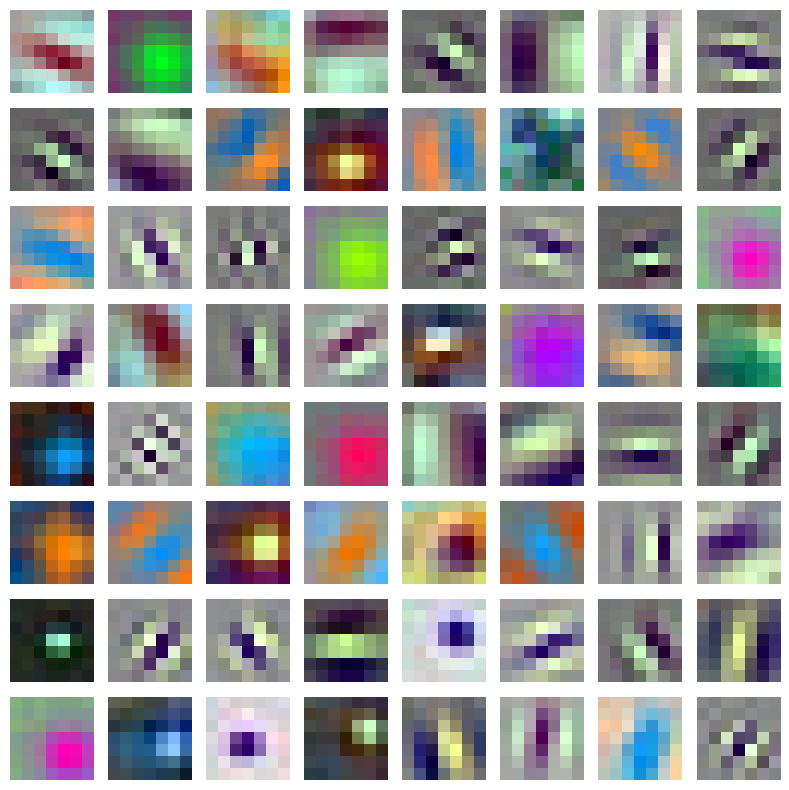

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 첫 번째 Conv Layer의 weight 가져오기
first_conv = model.conv1.weight.data.cpu()

# 정규화 함수 (0~1 스케일로)
def normalize(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

# 필터 시각화
def plot_conv_filters(tensor, num_cols=8):
    num_filters = tensor.shape[0]
    num_rows = int(np.ceil(num_filters / num_cols))

    plt.figure(figsize=(num_cols, num_rows))
    for i in range(num_filters):
        plt.subplot(num_rows, num_cols, i+1)
        # 필터 3채널 평균 → 흑백
        img = normalize(tensor[i])
        if img.shape[0] == 3:
            img = img.permute(1, 2, 0)  # CHW → HWC
        else:
            img = img[0]  # 1채널인 경우
        plt.imshow(img.numpy(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 실행
plot_conv_filters(first_conv)


In [ ]:
# 데이터셋에서 샘플 하나 가져오기
sample_img, sample_label = binary_dataset[0]  # 0번 이미지 (동물 or 비동물)

# 배치 차원 추가 (1, C, H, W)
sample_input = sample_img.unsqueeze(0).to(device)


In [ ]:
# 모델의 첫 번째 블록 출력 추출 (conv1 → bn1 → relu)
with torch.no_grad():
    x = model.conv1(sample_input)
    x = model.bn1(x)
    x = model.relu(x)  # [1, 64, 112, 112] 정도 크기 예상
    feature_maps = x.squeeze(0).cpu()  # 배치 제거


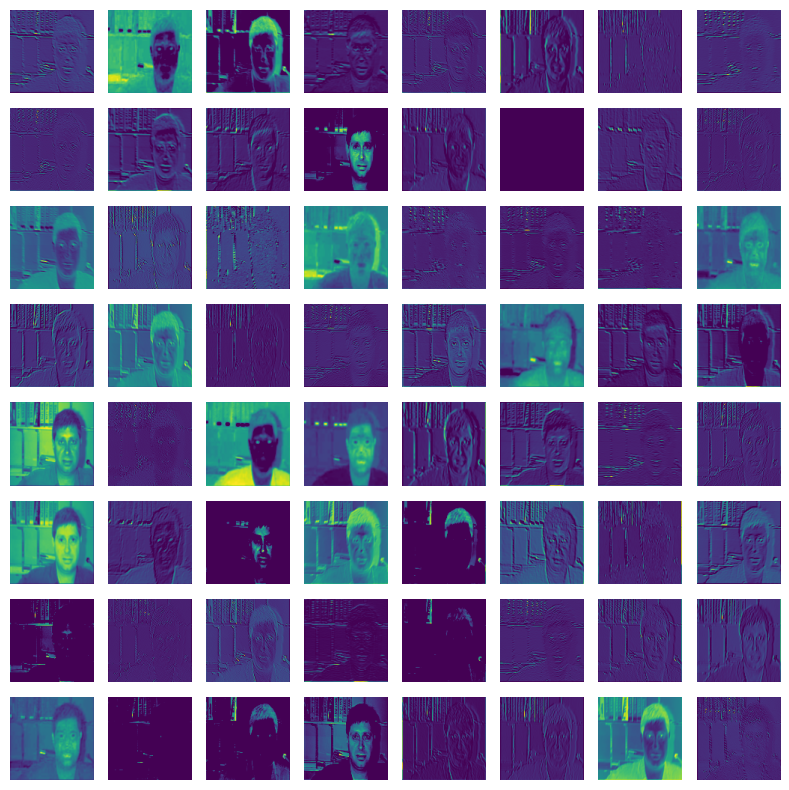

In [ ]:
def plot_feature_maps(feature_maps, num_cols=8):
    num_maps = feature_maps.shape[0]
    num_rows = int(np.ceil(num_maps / num_cols))

    plt.figure(figsize=(num_cols, num_rows))
    for i in range(num_maps):
        plt.subplot(num_rows, num_cols, i+1)
        fmap = feature_maps[i]
        plt.imshow(fmap.numpy(), cmap='viridis')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 실행
plot_feature_maps(feature_maps)
